# intro to HTS data
In this exercise will cover the following:

 - File formats (FASTQ, SAM/BAM, VCF)
 - Mapping (single-end, paired-end) NGS data to a reference sequence
 - Read flags
 - VERY IMPORTANT, you need to identify the 'pipe' button on your computer '|'. That is the character that looks like a vertical bar, on a standard American keyboard this can be found by pressing shift+'button left of enter' or 'button above enter

## Environment setup

In [1]:
# shared tools and data folder
source /home/student/USER/miniconda.sh
conda activate anders
TOOL_PATH=/home/student/opt/anders # for standalone tool script including java package
SHARED_PATH=/home/tch_wyd/myname/shared # For reference database
INPUT_PATH=/home/tch_wyd/myname/inputs/NGSIntro  # for input data

(base) (anders) (anders) (anders) (anders) 


In [2]:
NA19238_1_FQ=${INPUT_PATH}/fastq/NA19238.YRI.low_coverage.chr21_1.fq.gz
NA19238_2_FQ=${INPUT_PATH}/fastq/NA19238.YRI.low_coverage.chr21_2.fq.gz
CHR21=${INPUT_PATH}/human/chr21.fa.gz

# JAVA program
PICARD=${TOOL_PATH}/picard.jar

echo --programs that are installed:--
which samtools
which bwa
which angsd
which bcftools
ls $PICARD


echo --Datasets that will be use--\
echo pair of fastQ files
ls $NA19238_1_FQ
ls $NA19238_1_FQ

echo reference genome
ls $CHR21


(anders) (anders) (anders) (anders) (anders) (anders) (anders) --programs that are installed:--
(anders) /home/student/miniconda3/envs/anders/bin/samtools
(anders) /home/student/miniconda3/envs/anders/bin/bwa
(anders) /home/student/miniconda3/envs/anders/bin/angsd
(anders) /home/student/miniconda3/envs/anders/bin/bcftools
(anders) /home/student/opt/anders/picard.jar
(anders) (anders) (anders) --Datasets that will be use--echo pair of fastQ files
(anders) /home/tch_wyd/myname/inputs/NGSIntro/fastq/NA19238.YRI.low_coverage.chr21_1.fq.gz
(anders) /home/tch_wyd/myname/inputs/NGSIntro/fastq/NA19238.YRI.low_coverage.chr21_1.fq.gz
(anders) (anders) reference genome
(anders) /home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz
(anders) 


First make a folder for the exercise and had a symbolic link to the reference genomes and the fastQ files

In [3]:
#make folder and enter it
mkdir -p ~/sysu_day2_ngsintro
cd ~/sysu_day2_ngsintro

#make links to files and add them to the folder
cp -sf  $NA19238_1_FQ .
cp -sf  $NA19238_2_FQ .
cp -sf  ${CHR21}* .

echo --- files in folder ---
ls $NA19238_1_FQ $NA19238_2_FQ ${CHR21}*

(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) --- files in folder ---
(anders) /home/tch_wyd/myname/inputs/NGSIntro/fastq/NA19238.YRI.low_coverage.chr21_1.fq.gz
/home/tch_wyd/myname/inputs/NGSIntro/fastq/NA19238.YRI.low_coverage.chr21_2.fq.gz
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz.amb
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz.ann
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz.bwt
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz.pac
/home/tch_wyd/myname/inputs/NGSIntro/human/chr21.fa.gz.sa
(anders) 


In [4]:
# set up R working space
work_d <- path.expand("~/sysu_day2_ngsintro")
setwd(work_d)

In [5]:
# set up python working space
import os
work_d = os.path.expanduser("~/sysu_day2_ngsintro")
os.chdir(work_d)

## Mapping one reduced genome
In this exercise you will align a fastq file using bwa and generate a SAM file.

Due to the computational time we have created a reduced genome from one of the individuals from the 1000genomes pilot project. The individual, NA19238, has been sequenced using llumina. For this excerice we have created a reduced reference genome consisting only of chromosome 21 (the smallest human chromosome) and also reduced the sequencing data to reads that will likely map to chromosome 21 with the first 15Mb of the chromosome.  

 The fastQ file NA19238.YRI.low_coverage.chr21_1.fq.gz has variable name with *_1.fq.gz  which is first read or the read pair 
 
 We first want map both read pairs to the reference genome chr21.fa.gz.
 
 
 
### Viewing the input files

view the fastq file (NA19238......1.fq.gz) using the head command and identity the reads and quality scores (ignore the length)


In [33]:
# -n defermines the number of lines printed
gunzip -c NA19238.YRI.low_coverage.chr21_2.fq.gz | head -n 100


(anders) @SRR794309.186
GTTGGCGTGGGTGCAGTGATGAGGGAACACTTCTACACTGCTGGTGGGATTGTAAGCTAGTATAGCCACCACAGAAAACAGTGTGGAGATTTCTTAAAGA
+
CCCFFFFDHHHFHIIJEHIJJHIJJIJIJJJJJJJJJJJJJJJJFHIJGJHIGIJJJJHHEEEHHFFFFFDDDEDDDDDDDCCACDDDDDDDDEDDEDDD
@SRR794309.852
ATTTACCATTACTTTGTGGGATTGCTTTTGGTTTATTGTCCTGTTATTCTGATACTGAATTGATATTTTGCATGACAAGCCTTATTAATTTGCCAGAATT
+
CCCFFFFFHHHHHJJJGIJJIJJJJJJJJIJHIJIJJBIIJJJHIJJJJJIJJJJJJJJJJJIIJJJJJIJJJJJJJJJHHHHHFFFFFFFEEEEEEDDD
@SRR794309.869
GCTTTGTGATGTGTGCATTCATCTCACAGGGTTGAACCTAGGTTATGATTGAGCAGTTTTGAAACACTCTTTTTGTAGGATCTTCAAGTGGATATTTGGA
+
CCCFFFDFGHHHHHIJJJJJJJJJIIJJJJJIHJIJJJJJJJDGIJJIJJIJJJJIFHIJIIJJIJIIJJJJJJHHHHHFFFFFFFEECEEDDEDEFEDD
@SRR794309.2365
ATGGAACAACCCGAATGGAATGGAATGTAGTGGAGAGTAAGGGAGTTGAATAGAATCAATCCGAATGTAATGGAATGGAATGCAACGGAATGGGATGGAA
+
@<@BDAA<DF?CFB@FCEC<BACBBFH9??1?D*?3?0:BFEH9?0?8CC<==B@@4=;47;;?ACE3?;?@;3;>C;(6;;@ACC@B?BBC@(9:8??A
@SRR794309.2601
TTATATGCTTTCATTGTTGCTTTGGACTAAAAGTAAAACCCCATCTATGAGCCACACTGTTCACTAATCCAAGAAAATACATGTCACTGTGATTTTAG

 - identify the read names, the sequence, the base quality scores. Fill in the ???? below
<code>
?????        @SRR794309.186 
?????        GTTGGCGTGGGTGCAGTGATGAGGGAACACTTCTACACTGCTGGTGGGATTGTAAGCTAGTATAGCCACCACAGAAAACAGTGTGGAGATTTCTTAAAGA
        +
?????        CCCFFFFDHHHFHIIJEHIJJHIJJIJIJJJJJJJJJJJJJJJJFHIJGJHIGIJJJJHHEEEHHFFFFFDDDEDDDDDDDCCACDDDDDDDDEDDEDDD
</code>
View the reference fasta file (chr21.fa.gz) using the head command.

The below command count the number of lines in the file
 - How many lines to you have ????
 - How many Reads in the data ????
 - is the number of lines the same in the 2 fastQ files ???? ( modify the code below to see the number of lines in the other file)

In [7]:
gunzip -c NA19238.YRI.low_coverage.chr21_2.fq.gz |  wc -l

687520
(anders) 


View the reference fasta file (chr21.fa.gz) using the head command. The first many bases of the refence genome is all Ns ( unknown bases).
First view the first bases of chr21 then then try to view other parts. You can modify the below uncommented code below



In [8]:
# first 20 lines
gunzip -c chr21.fa.gz | head -n 20

# last 100 lines of the first million  lines (uncomment and modify below)
# gunzip -c chr21.fa.gz | head -n 1000000 | tail -n 100

(anders) >chr21
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

gzip: stdout: 


## Aligning

Align the reads using bwa. We use bwa in the exercises because it is fast and widely used. We first need to index the reference chromosome, followed by the actual aligning process. If should take around 1 min to finish. 


In [9]:
## # we will use the prepared index files
# bwa index chr21.fa.gz

(anders) (anders) 


Once the index is made, the second step is to map the reads. There are several ways to do this, but I suggest you use the bwa mem mode, which is the most commonly used these days. Again you can run it with no arguments to get info about how to use it. 

In [10]:
# see options
bwa mem

(anders) 
Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]

Algorithm options:

       -t INT        number of threads [1]
       -k INT        minimum seed length [19]
       -w INT        band width for banded alignment [100]
       -d INT        off-diagonal X-dropoff [100]
       -r FLOAT      look for internal seeds inside a seed longer than {-k} * FLOAT [1.5]
       -y INT        seed occurrence for the 3rd round seeding [20]
       -c INT        skip seeds with more than INT occurrences [500]
       -D FLOAT      drop chains shorter than FLOAT fraction of the longest overlapping chain [0.50]
       -W INT        discard a chain if seeded bases shorter than INT [0]
       -m INT        perform at most INT rounds of mate rescues for each read [50]
       -S            skip mate rescue
       -P            skip pairing; mate rescue performed unless -S also in use

Scoring options:

       -A INT        score for a sequence match, which scales options -TdBOELU unless overridden 

The number of options may be a bit overwhelming, but you can run it with no additional options, although I suggest you add "-t 5" to run 5 threads if your computer has multiple cores. It reads the compressed fastq files directly, so you need not decompress them. By default the result comes on stdout (in the terminal), so you have to redirect to a file, like the below command. 
We also want to add a read group name with information about where the reads comes from. This is very usefull if you have sequencing data from multiple libraries.  
Now try to align the data


In [11]:
#align the data ( take ~ 1 min)
bwa mem -R '@RG\tID:foo\tSM:bar\tLB:library1' -t 5 chr21.fa.gz NA19238.YRI.low_coverage.chr21_1.fq.gz NA19238.YRI.low_coverage.chr21_2.fq.gz  > NA19238.sam


(anders) [M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 343760 sequences (34376000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (12, 93011, 73, 12)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (548, 1375, 6799)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 19301)
[M::mem_pestat] mean and std.dev: (2500.67, 3111.22)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 25552)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (134, 170, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 398)
[M::mem_pestat] mean and std.dev: (181.60, 65.41)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 486)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (559, 1777, 4330)
[M::mem_pest

Lets look at the generated sam file

In [12]:
# view first 100 lines
head -n100 NA19238.sam

(anders) @HD	VN:1.5	SO:unsorted	GO:query
@SQ	SN:chr21	LN:46944323
@RG	ID:foo	SM:bar	LB:library1
@PG	ID:bwa	PN:bwa	VN:0.7.19-r1273	CL:bwa mem -R @RG\tID:foo\tSM:bar\tLB:library1 -t 5 chr21.fa.gz NA19238.YRI.low_coverage.chr21_1.fq.gz NA19238.YRI.low_coverage.chr21_2.fq.gz
SRR794309.186	99	chr21	16239093	60	100M	=	16239300	307	CCTTTTTATGGCTGAGTAGTATTCCACAGTTTCTTTACCCACTCCTTGATCAATAGGCACTTGGGTTGGTTCCACGATTTTGCATTTGTGAATTGTGTTG	CCCFFFFFHHHHHJJJFHIFHHJIJJJJJHIJJJJJIIJJJJJJJJJIHIIJJJJJJJJJJJJJJFHIJHFHHHHFFFDDEEEEEEDEACCEEECDCCDD	NM:i:0	MD:Z:100	MC:Z:100M	MQ:i:60	AS:i:100	XS:i:26	RG:Z:foo
SRR794309.186	147	chr21	16239300	60	100M	=	16239093	-307	TCTTTAAGAAATCTCCACACTGTTTTCTGTGGTGGCTATACTAGCTTACAATCCCACCAGCAGTGTAGAAGTGTTCCCTCATCACTGCACCCACGCCAAC	DDDEDDEDDDDDDDDCACCDDDDDDDEDDDFFFFFHHEEEHHJJJJIGIHJGJIHFJJJJJJJJJJJJJJJJIJIJJIHJJIHEJIIHFHHHDFFFFCCC	NM:i:0	MD:Z:100	MC:Z:100M	MQ:i:60	AS:i:100	XS:i:39	RG:Z:foo
SRR794309.852	83	chr21	18423539	60	100M	=	18423474	-165	TTTTGCATGACAAGCCTTATTAATTTGCCAGAATTA

You can read about the sam output here: https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2017/Day1/Session5-alignedReads.html  

 - Identify the header and explain its contents. 
 - For the first read identify the following and fill in the (?????) below
     - the chromosome
     - the position of the first base of the read 
     - The mapping qualty
     - The alignment (cigar string)
     - the insert size (template length)
     - the read(the bases)
     - the base qualities
 <code>
 SRR794309.186	(the name of the read)
 99 			(FLAGS)
 chr21			(?????)
 16239093		(?????
 60				(?????
 100M			(?????
 =				(name of the mate is the same)
 16239300		(position of the mate)
 307			(?????)
 CCTTTTTATGGCTGAGTAGTATTCCACAGTTTCTTTACCCACTCCTTGATCAATAGGCACTTGGGTTGGTTCCACGATTTTGCATTTGTGAATTGTGTTG		(?????)
 CCCFFFFFHHHHHJJJFHIFHHJIJJJJJHIJJJJJIIJJJJJJJJJIHIIJJJJJJJJJJJJJJFHIJHFHHHHFFFDDEEEEEEDEACCEEECDCCDD		(?????)
 NM:i:0	MD:Z:100	MC:Z:100M	AS:i:100	XS:i:26	RG:Z:foo  (TAGS)
 </code>
 
 
 To understand the flags (second column in the sam format) you can type a flag into this page and get the meaning: https://broadinstitute.github.io/picard/explain-flags.html
 


Lets try to find the number of reads  in the samfile.


In [13]:
wc -l NA19238.sam 

345795 NA19238.sam
(anders) 


Why is it not the same number as in the fastQ file?



Fortunately there are tools to handle sam files, which will make your life easier. We will use the samtools program. First, you often need the compressed version of the sam format, which is called bam. You use samtools view for converting between formats. BAM files faciliates random access to genomic regions, but this requires the file to be sorted and requires  an index this is generated using the command below.
Converting sam to bam is done like this:

In [14]:
#sam to bam
samtools view -b NA19238.sam > NA19238.bam
#sort bam file
samtools sort -o NA19238.sorted.bam NA19238.bam
#index bam file
samtools index NA19238.sorted.bam

#see sizes
echo --- files sizes ---
ls -lah NA19238.sam NA19238.bam NA19238.sorted.bam

(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) --- files sizes ---
(anders) -rw-r--r-- 1 tch_myname student  35M 7月  26 11:50 NA19238.bam
-rw-r--r-- 1 tch_myname student 107M 7月  26 11:50 NA19238.sam
-rw-r--r-- 1 tch_myname student  30M 7月  26 11:50 NA19238.sorted.bam
(anders) 


The bam file is a compressed version of sam, you can see it is about one-third of the sam file in size. 



We now have a functional alignment file that we can use for analysis. Lets first to view the alignment at different part of the chromosome 21. We will use tview to extact alignment. The option -d -w print  150 bases of the alignment to the terminal

In [15]:
samtools tview NA19238.sorted/home/student/miniconda3/envs/anders/bin/R.bam  -d T -w 150 -p chr21:10002000

[E::hts_open_format] Failed to open file "NA19238.sorted/home/student/miniconda3/envs/anders/bin/R.bam" : No such file or directory
samtools tview: can't open "NA19238.sorted/home/student/miniconda3/envs/anders/bin/R.bam": No such file or directory
(anders) 


In the above the lines are

Line1: The position on chromome 21

Line2: The refence genome ( N if not provided)

Line3: The concensus sequence (If all reads have a G then the concensus is G)

Line4+:  (lines 4,5 ect) the reads alignment


- When looking at the region starting with position chr21:10002000 can you find a possible variable site?
- look at chr21:10028350. Do you think there are problems with the alignment at this position?
- look at chr21:10042151. is this a variable site or is there another likely explanation?

Lets try to add the referecne genome to make it esiaer to see the sequencing error and variable sites

In [16]:
samtools tview NA19238.sorted.bam  -d T -w 150 -p chr21:10042151 chr21.fa.gz

10042151  10042161  10042171  10042181  10042191  10042201  10042211  10042221  10042231  10042241  10042251  10042261  10042271  10042281  10042291  
AGGTTCCCCAGAAAGCCTCTATCCTGAAATGCTTGAAAGTGAGCAGTGCTGACTCTCGATTATTACCAATTGCATTAAATATGACACTTGTTTTGTTTCTTTTGGCTATAAGGAGAAAATGTCATTTTGTATATGAGTGAGCACAGAGGA
.S....................M...............................................................................................................................
..,,,,,,,,,,,,,,,,,,,,a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,t,,,,,,,,,,,,...................................C............
.................................................................................................................................    .................
,c,,,,,,,,,,,,,,,,,,,,a,,,,,,,,,,,, ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,c,,,,,,,,,,,,,,, .............
......................................                    ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

 - How many likelely variable sites can you see?
 - Is is possible that both of the first two sites (sites 10042151 and 10042152) are heterzygoes sites?
 - Have a look at the region staring with 9719896. Do you think the variable sites in this region are reliable (why/why not)?
 
 
 Another way to look at the genome is by generating a [pileup](http://samtools.sourceforge.net/samtools.shtml) format

In [17]:
# see first 1000 sites where there is data
samtools mpileup NA19238.sorted.bam  | head -n 1000

(anders) [mpileup] 1 samples in 1 input files
chr21	2627371	N	1	^!c	j
chr21	2627372	N	1	g	j
chr21	2627373	N	1	g	i
chr21	2627374	N	1	t	c
chr21	2627375	N	1	t	\
chr21	2627376	N	1	c	i
chr21	2627377	N	1	c	l
chr21	2627378	N	1	c	k
chr21	2627379	N	1	t	f
chr21	2627380	N	1	c	k
chr21	2627381	N	1	c	g
chr21	2627382	N	1	a	`
chr21	2627383	N	1	c	j
chr21	2627384	N	1	t	j
chr21	2627385	N	1	g	h
chr21	2627386	N	1	g	j
chr21	2627387	N	1	c	j
chr21	2627388	N	1	c	j
chr21	2627389	N	1	a	j
chr21	2627390	N	1	c$	i
chr21	9719768	N	3	^]A^IA^]A	I2J
chr21	9719769	N	3	AA^]a	JJf
chr21	9719770	N	3	TTt	JJ`
chr21	9719771	N	3	TTt	IJ`
chr21	9719772	N	3	CCc	JIm
chr21	9719773	N	3	TTt	JJp
chr21	9719774	N	3	GGg	JJp
chr21	9719775	N	3	AAa	JJi
chr21	9719776	N	3	GGg	JJm
chr21	9719777	N	4	AAa^]A	JJnC
chr21	9719778	N	4	AAaA	JJnC
chr21	9719779	N	4	AAaA	JJcC
chr21	9719780	N	4	CCcC	JJlF
chr21	9719781	N	4	TTtT	GJ`F
chr21	9719782	N	4	TTtT	IJ_F
chr21	9719783	N	4	CCcC	JJhF
chr21	9719784	N	4	TTtT	GJfF
chr21	9719785	N	4	TTtT	IJbH
chr21	9719786	N


Each line is a position with data.
 - When is this a format particually usefull?
 
 
 From the pileup it is easiy to get the sequencing depth distribution

In [18]:
samtools mpileup NA19238.sorted.bam | cut -f4 | sort -n | uniq -c >dep2
cat dep2

[mpileup] 1 samples in 1 input files
(anders)   25825 0
1695978 1
1490927 2
 983210 3
 533492 4
 258288 5
 131997 6
  74765 7
  50562 8
  37783 9
  31624 10
  27170 11
  25113 12
  22220 13
  19730 14
  17717 15
  16969 16
  14933 17
  13215 18
  11743 19
   9890 20
   8588 21
   7398 22
   6299 23
   5549 24
   4932 25
   4114 26
   3538 27
   3307 28
   2804 29
   2345 30
   2360 31
   2251 32
   1989 33
   1739 34
   1665 35
   1539 36
   1265 37
   1139 38
   1044 39
    934 40
    818 41
    657 42
    615 43
    571 44
    513 45
    428 46
    454 47
    398 48
    402 49
    352 50
    336 51
    386 52
    311 53
    315 54
    288 55
    261 56
    187 57
    186 58
    163 59
    157 60
    165 61
    119 62
     93 63
    117 64
    112 65
    146 66
     90 67
     70 68
    103 69
     89 70
     65 71
     82 72
     85 73
     90 74
     70 75
     77 76
    122 77
     92 78
    102 79
     85 80
    102 81
    100 82
     80 83
     90 84
    103 85
     87 86
     59


the left column is the number of sites and the right is the depth. 

View the distribution for this individuals using the following R command


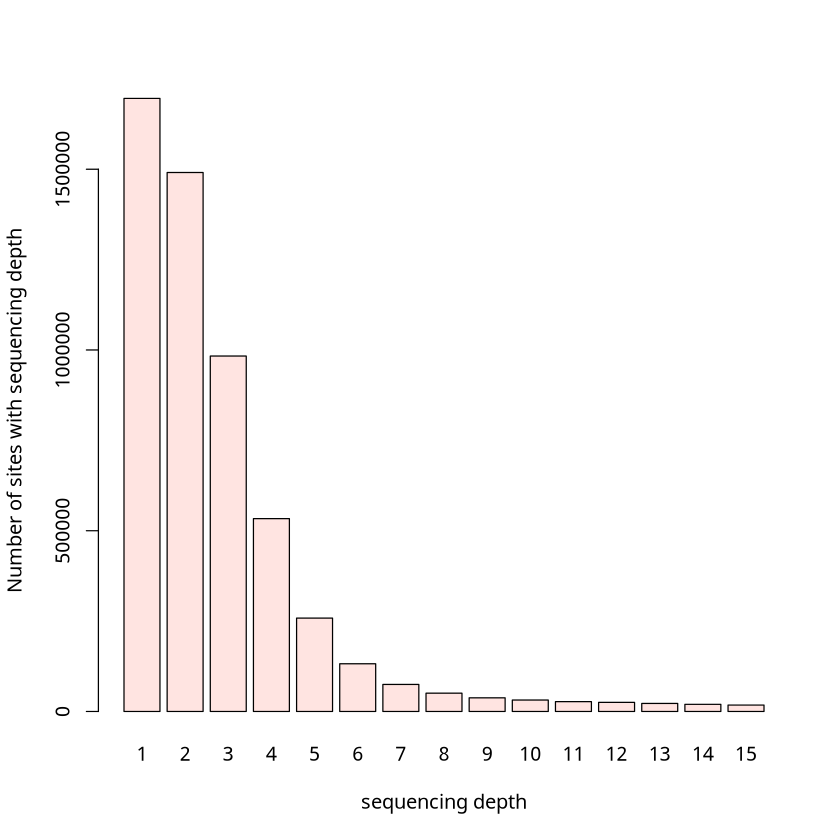

In [19]:
depth <- read.table("dep2")
d <- 1:15 #chosen depths to plot

barplot(depth[d+1,1],names=d,xlab="sequencing depth",ylab="Number of sites with sequencing depth ",col="mistyrose")


 - How do you think the depth will affect genotype and variant calling?
 
 First lets view the mpileup with the reference

In [34]:
samtools mpileup -f chr21.fa.gz NA19238.sorted.bam | head -n 300

[mpileup] 1 samples in 1 input files
chr21	2627371	N	0	*	*
chr21	2627372	N	0	*	*
chr21	2627373	N	0	*	*
chr21	2627374	N	0	*	*
chr21	2627375	N	0	*	*
chr21	2627376	N	0	*	*
chr21	2627377	N	0	*	*
chr21	2627378	N	0	*	*
chr21	2627379	N	0	*	*
chr21	2627380	N	0	*	*
chr21	2627381	N	0	*	*
chr21	2627382	N	0	*	*
chr21	2627383	N	0	*	*
chr21	2627384	N	0	*	*
chr21	2627385	N	0	*	*
chr21	2627386	N	0	*	*
chr21	2627387	N	0	*	*
chr21	2627388	N	0	*	*
chr21	2627389	N	0	*	*
chr21	2627390	N	0	*	*
chr21	9719768	A	3	^].^I.^].	<2<
chr21	9719769	a	3	..^],	??P
chr21	9719770	t	3	..,	JJ`
chr21	9719771	t	3	..,	IJ`
chr21	9719772	c	3	..,	JIm
chr21	9719773	t	3	..,	JJp
chr21	9719774	g	3	..,	JJp
chr21	9719775	a	3	..,	JJi
chr21	9719776	g	3	..,	JJm
chr21	9719777	a	4	..,^].	JJnA
chr21	9719778	a	4	..,.	JJnB
chr21	9719779	a	4	..,.	JJcC
chr21	9719780	c	4	..,.	JJlF
chr21	9719781	t	4	..,.	GJ`F
chr21	9719782	t	4	..,.	IJ_F
chr21	9719783	c	4	..,.	JJhF
chr21	9719784	t	4	..,.	GJfF
chr21	9719785	t	4	..,.	IJbH
chr21	9719786	t	4	..,.	JIjH

 - Can you see the difference compared to not using the referecne genome. 
 - Can you identify a heterozygoes site? (e.g. position 9719896)
 
 
 ### Variant calling 
  Lets create a VCF file for the first couple of MB of chr21. This is done based on the mpileup. There will be much more information tomorrow about how the calling is done using genotype likelihoods. However, before doing so we should remove duplicated reads ( read with the same starting points) as they are likely PCR duplicate

In [21]:
## remove duplicates
samtools rmdup -s NA19238.sorted.bam NA19238.md.bam

## call variants
bcftools mpileup -Ou -f chr21.fa.gz NA19238.md.bam | bcftools call -mv -Ov -o NA19238.vcf

(anders) (anders) (anders) (anders) Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
(anders) 


Lets have a look at the VCF file

In [22]:
head -n 200 NA19238.vcf 

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.22+htslib-1.22.1
##bcftoolsCommand=mpileup -Ou -f chr21.fa.gz NA19238.md.bam
##reference=file://chr21.fa.gz
##contig=<ID=chr21,length=46944323>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Read Position Bias (closer to 0 is better)">
##INFO=<ID=MQBZ,Number=1,Type=Float,Description="Mann-Whitney U


 The header of the VCF contains meta information about what it in the file.
In the body of the file
 - Identify the position, the reference allele and the alternative allele of the file.
 - Identify the depth of each position
 - Find a tri-allelic site. Do you believe that it is truely triallelic?
 - How many sites are are called as variable?
 
 
 
 # Bonus exercise (Only do this part if you have finished the rest) 
 ## Bonus exercise 1 -  duplicated reads using Picardtools
 
 bwa actually fills in the mate information, but not all aligners do that, so we can run picard tools to fill in the mate information and sort the file according to position. We will output the file in the binary version of SAM which is BAM

In [23]:

java -jar  ${TOOL_PATH}/picard.jar FixMateInformation INPUT=NA19238.sam \
OUTPUT=id.fixmate.srt.bam SORT_ORDER=coordinate

INFO	2025-07-26 11:51:20	FixMateInformation	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    FixMateInformation -INPUT NA19238.sam -OUTPUT id.fixmate.srt.bam -SORT_ORDER coordinate
**********


11:51:20.366 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/student/opt/anders/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sat Jul 26 11:51:20 CST 2025] FixMateInformation INPUT=[NA19238.sam] OUTPUT=id.fixmate.srt.bam SORT_ORDER=coordinate    ASSUME_SORTED=false ADD_MATE_CIGAR=true IGNORE_MISSING_MATES=true VERBOSITY=INFO QUIET=false VALIDATION_STRINGENCY=STRICT COMPRESSION_LEVEL=5 MAX_RECORDS_IN_RAM=500000 CREATE_INDEX=false CREATE_MD5_FILE=false USE_JDK_DEFLATER=false USE_J

View the header of the BAM file

In [24]:
samtools view -H id.fixmate.srt.bam 

@HD	VN:1.6	SO:coordinate	GO:query
@SQ	SN:chr21	LN:46944323
@RG	ID:foo	SM:bar	LB:library1
@PG	ID:bwa	PN:bwa	VN:0.7.19-r1273	CL:bwa mem -R @RG\tID:foo\tSM:bar\tLB:library1 -t 5 chr21.fa.gz NA19238.YRI.low_coverage.chr21_1.fq.gz NA19238.YRI.low_coverage.chr21_2.fq.gz
@PG	ID:samtools	PN:samtools	PP:bwa	VN:1.22.1	CL:samtools view -H id.fixmate.srt.bam
(anders) 


picard didn't update the PG flag, so let us update the header information so that we have documented how we modified the file.

In [25]:

(samtools view -H id.fixmate.srt.bam;echo -e "@PG\tID:fixmate\tPN:fixmate\tVN:2.60\tCL:stuff" ) >newhd
samtools reheader newhd id.fixmate.srt.bam > id.fixmate.srt2.bam


(anders) (anders) 


 - Validate that the header in file id.fixmate.srt2.bam  has been updated

In [26]:
samtools view -H id.fixmate.srt2.bam 

@HD	VN:1.6	SO:coordinate	GO:query
@SQ	SN:chr21	LN:46944323
@RG	ID:foo	SM:bar	LB:library1
@PG	ID:bwa	PN:bwa	VN:0.7.19-r1273	CL:bwa mem -R @RG\tID:foo\tSM:bar\tLB:library1 -t 5 chr21.fa.gz NA19238.YRI.low_coverage.chr21_1.fq.gz NA19238.YRI.low_coverage.chr21_2.fq.gz
@PG	ID:samtools	PN:samtools	PP:bwa	VN:1.22.1	CL:samtools view -H id.fixmate.srt.bam
@PG	ID:fixmate	PN:fixmate	VN:2.60	CL:stuff
@PG	ID:samtools.1	PN:samtools	PP:samtools	VN:1.22.1	CL:samtools reheader newhd id.fixmate.srt.bam
@PG	ID:samtools.2	PN:samtools	PP:samtools.1	VN:1.22.1	CL:samtools view -H id.fixmate.srt2.bam
(anders) 


Now mark duplicates using picard

In [27]:

java -jar  ${TOOL_PATH}/picard.jar MarkDuplicates I=id.fixmate.srt2.bam \
O=id.fixmate.srt.md.bam  M=metrics;


INFO	2025-07-26 11:51:27	MarkDuplicates	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MarkDuplicates -I id.fixmate.srt2.bam -O id.fixmate.srt.md.bam -M metrics
**********


11:51:27.067 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/student/opt/anders/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sat Jul 26 11:51:27 CST 2025] MarkDuplicates INPUT=[id.fixmate.srt2.bam] OUTPUT=id.fixmate.srt.md.bam METRICS_FILE=metrics    MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP=50000 MAX_FILE_HANDLES_FOR_READ_ENDS_MAP=8000 SORTING_COLLECTION_SIZE_RATIO=0.25 TAG_DUPLICATE_SET_MEMBERS=false REMOVE_SEQUENCING_DUPLICATES=false TAGGING_POLICY=DontTag CLEAR_DT=true DUPLEX_UMI=false FLOW_MODE=

 - Did picard update the PG flag of the header?
 - Did picard update anything else in the header?

NB you can view the header of a bamfile using 'samtools view -H'




In [28]:
samtools view -H id.fixmate.srt.md.bam

@HD	VN:1.6	SO:coordinate	GO:query
@SQ	SN:chr21	LN:46944323
@RG	ID:foo	SM:bar	LB:library1
@PG	ID:bwa	PN:bwa	VN:0.7.19-r1273	CL:bwa mem -R @RG\tID:foo\tSM:bar\tLB:library1 -t 5 chr21.fa.gz NA19238.YRI.low_coverage.chr21_1.fq.gz NA19238.YRI.low_coverage.chr21_2.fq.gz
@PG	ID:samtools	PN:samtools	PP:bwa	VN:1.22.1	CL:samtools view -H id.fixmate.srt.bam
@PG	ID:fixmate	PN:fixmate	VN:2.60	CL:stuff
@PG	ID:samtools.1	PN:samtools	PP:samtools	VN:1.22.1	CL:samtools reheader newhd id.fixmate.srt.bam
@PG	ID:MarkDuplicates	VN:3.4.0	CL:MarkDuplicates INPUT=[id.fixmate.srt2.bam] OUTPUT=id.fixmate.srt.md.bam METRICS_FILE=metrics    MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP=50000 MAX_FILE_HANDLES_FOR_READ_ENDS_MAP=8000 SORTING_COLLECTION_SIZE_RATIO=0.25 TAG_DUPLICATE_SET_MEMBERS=false REMOVE_SEQUENCING_DUPLICATES=false TAGGING_POLICY=DontTag CLEAR_DT=true DUPLEX_UMI=false FLOW_MODE=false FLOW_DUP_STRATEGY=FLOW_QUALITY_SUM_STRATEGY FLOW_USE_END_IN_UNPAIRED_READS=false FLOW_USE_UNPAIRED_CLIPPED_END=false FLOW_UNP



## Bonus exercise 2 - clean you bam files using the FLAGS column

The second column in the SAM format is the very important FLAG. This will tell tell you about the state of the paired end mapping, QC duplicates etc.


  
Using the samtools -F/-f you can discard/include flags that fulfill certain patterns. See http://broadinstitute.github.io/picard/explain-flags.html .

  1. How many reads have we marked as duplicate in the final file.
  2. How many properly mapped read pairs do we have? (Where both reads map to the same chr etc).
  3. How many mapped reads do we have ?
  4. How many unmapped reads do we have ?
  5. Find the distribution of the RNAMES of the unmapped reads!?

 Run the following command one at a time by uncommenting them

In [29]:



#samtools view -f 1024 id.fixmate.srt.md.bam|wc -l
#samtools view -f 2 id.fixmate.srt.md.bam|wc -l
#samtools view -F 4 id.fixmate.srt.md.bam|wc -l
#samtools view -f 4 id.fixmate.srt.md.bam|wc -l
# samtools view -f 4 id.fixmate.srt.md.bam|cut -f3|sort -n |uniq -c




(anders) (anders) (anders) (anders) (anders) 


Compare with "samtools flagstat" command 


In [30]:
samtools flagstat id.fixmate.srt.md.bam


345791 + 0 in total (QC-passed reads + QC-failed reads)
343760 + 0 primary
0 + 0 secondary
2031 + 0 supplementary
5777 + 0 duplicates
5777 + 0 primary duplicates
280770 + 0 mapped (81.20% : N/A)
278739 + 0 primary mapped (81.09% : N/A)
343760 + 0 paired in sequencing
171880 + 0 read1
171880 + 0 read2
269744 + 0 properly paired (78.47% : N/A)
275806 + 0 with itself and mate mapped
2933 + 0 singletons (0.85% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
(anders) 


Make a new bamfile, where you only the reads where both ends maps, and filter out those with a mapping quality below 10, and removing duplicates


In [31]:
samtools view -f 2 -F 1/home/student/miniconda3/envs/anders/bin/R024 id.fixmate.srt.md.bam -q 10 >new.bam

(anders) 


In [32]:
# type your code here


(anders) 
